In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter

In [ ]:
data = pd.read_csv("./train.csv")
subspures = pd.read_csv("./substances.csv")
pure_heroin = subspures[(subspures['substance'] == 'heroin (white)') | (subspures["substance"]=="heroin (brown)")]

(1432, 126)

In [7]:
np.linalg.norm(data.iloc[:,6:].values, axis=1)

array([0.19460235, 0.49730442, 0.44574007, ..., 0.72658572, 0.52350438,
       0.44749065])

In [3]:
distances = cdist(data.iloc[:,6:].to_numpy(), pure_heroin.iloc[:, 1:].to_numpy(), metric = 'euclidean')
dist_her = pd.DataFrame(distances, index = data.iloc[:,6:].index, columns=pure_heroin.iloc[:,1:].index)

In [12]:
normalized_data = preprocessing.normalize(data.iloc[:, 6:].values)
normalized_substances = preprocessing.normalize(subspures.iloc[:,1:].values)
data_new_features2 = data.iloc[:, 6:].values.dot(subspures.iloc[:,1:].values.T)
print(data_new_features2.shape)

(1300, 1432)


Nombre de composantes pour 95% de variance : 2


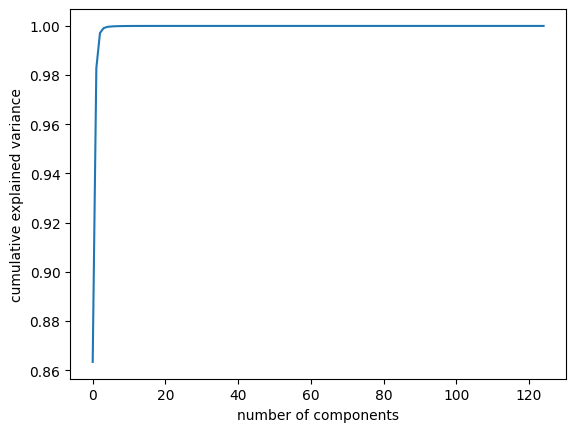

In [38]:
spectrum = data_new_features2
spectrum_filtered = pd.DataFrame(savgol_filter(spectrum, 7, 3, deriv = 2, axis = 1))

X = data_new_features2
y = data['PURITY']

pca = PCA()
X_pca = pca.fit_transform(data.iloc[:, 6:].values)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

# Calcul de la variance expliquée cumulée
cumulative_variance = pca.explained_variance_ratio_.cumsum()
# Trouver le nombre de composantes pour expliquer 95% de la variance
n_components_95 = (cumulative_variance >= 0.95).argmax() + 1
print(f"Nombre de composantes pour 95% de variance : {n_components_95}")
# Perform PCA 
pca = PCA(150)
pca.fit(X)
X_pca = pca.transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X_pca, y, test_size=0.15, random_state=42)

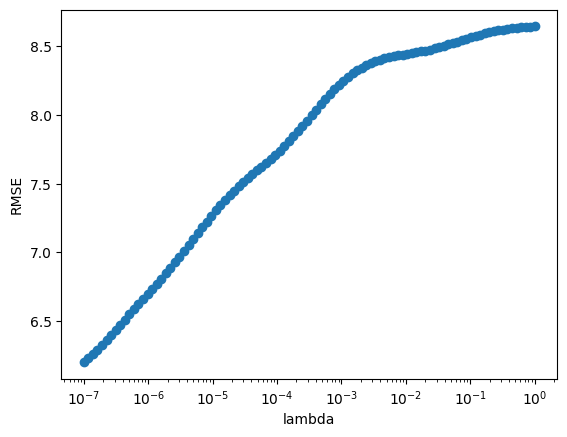

In [39]:
model = Ridge() #ridge regressors model
param_grid = {'alpha': np.logspace(-7, 0, 100)} #hyperparamater alpha

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

mach1 = grid_search.best_estimator_ #best model
mach1.fit(X_train, y_train) #apply the best model to the data
predictions = mach1.predict(X_valid)

plt.figure()
plt.scatter(np.logspace(-7, 0, 100),        
            np.sqrt(-grid_search.cv_results_['mean_test_score']))
plt.xlabel("lambda")
plt.ylabel("RMSE")
plt.xscale("log")
plt.show()

In [40]:
mach1.get_params()

{'alpha': 1e-07,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [41]:
y_pred1 = mach1.predict(X_train)
y_pred2 = mach1.predict(X_valid)
train_score = np.mean(np.abs(y_pred1-y_train)<=5)
test_score = np.mean(np.abs(y_pred2-y_valid)<=5)
print("Train score ridge :", train_score)
print("Test score ridge :", test_score)

Train score ridge : 0.6307692307692307
Test score ridge : 0.7025641025641025
